In [14]:
!pip install stable-baselines3 gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 4.3 MB/s eta 0:00:00


model-free

Starting TD3 agent training...


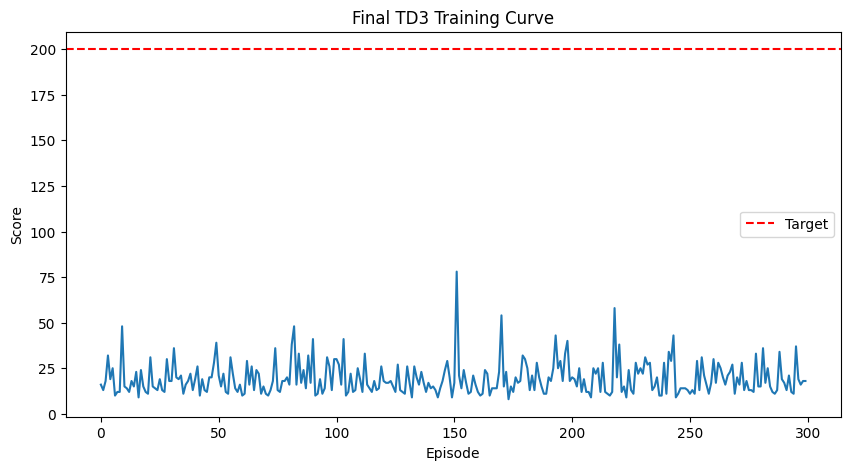

Episode 50	Average Score: 18.76
Episode 100	Average Score: 19.21
Episode 150	Average Score: 18.76
Episode 200	Average Score: 19.48
Episode 250	Average Score: 20.26
Episode 300	Average Score: 19.22

Sample efficiency (steps to reach target): None

Testing robustness under different friction coefficients...
Friction coefficient 0.001, Episode 1/5, Score: 17.0
Friction coefficient 0.001, Episode 2/5, Score: 9.0
Friction coefficient 0.001, Episode 3/5, Score: 14.0
Friction coefficient 0.001, Episode 4/5, Score: 25.0
Friction coefficient 0.001, Episode 5/5, Score: 24.0


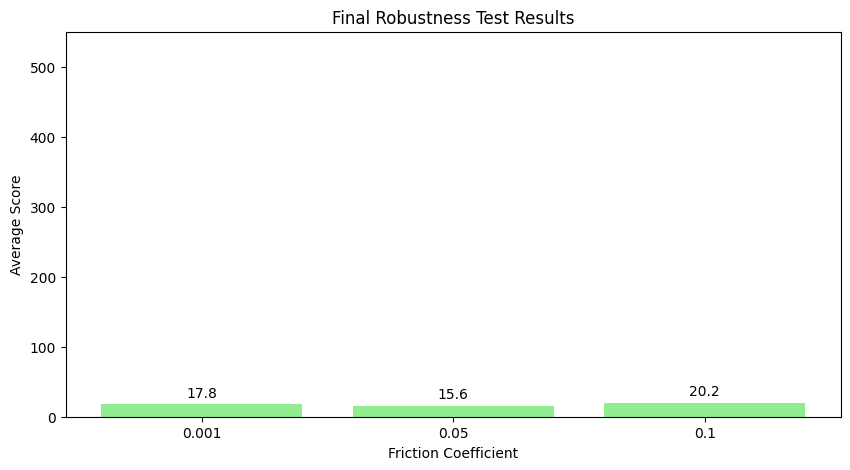

Friction coefficient 0.05, Episode 1/5, Score: 17.0
Friction coefficient 0.05, Episode 2/5, Score: 23.0
Friction coefficient 0.05, Episode 3/5, Score: 13.0
Friction coefficient 0.05, Episode 4/5, Score: 12.0
Friction coefficient 0.05, Episode 5/5, Score: 13.0
Friction coefficient 0.1, Episode 1/5, Score: 21.0
Friction coefficient 0.1, Episode 2/5, Score: 24.0
Friction coefficient 0.1, Episode 3/5, Score: 17.0
Friction coefficient 0.1, Episode 4/5, Score: 22.0
Friction coefficient 0.1, Episode 5/5, Score: 17.0

Robustness test results:
Friction coefficient 0.001: Average score 17.80, Success rate 0.00
Friction coefficient 0.05: Average score 15.60, Success rate 0.00
Friction coefficient 0.1: Average score 20.20, Success rate 0.00

Measuring planning latency...
Planning latency (per-step inference time): 0.0444 milliseconds

Displaying agent performance...


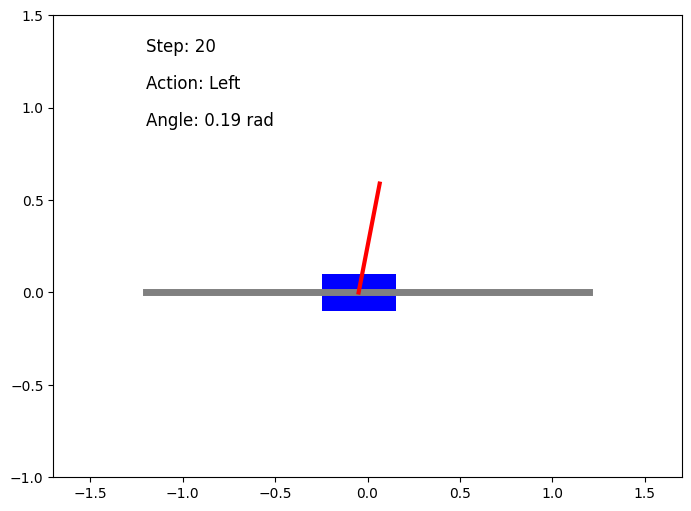

Episode ended after 20 steps


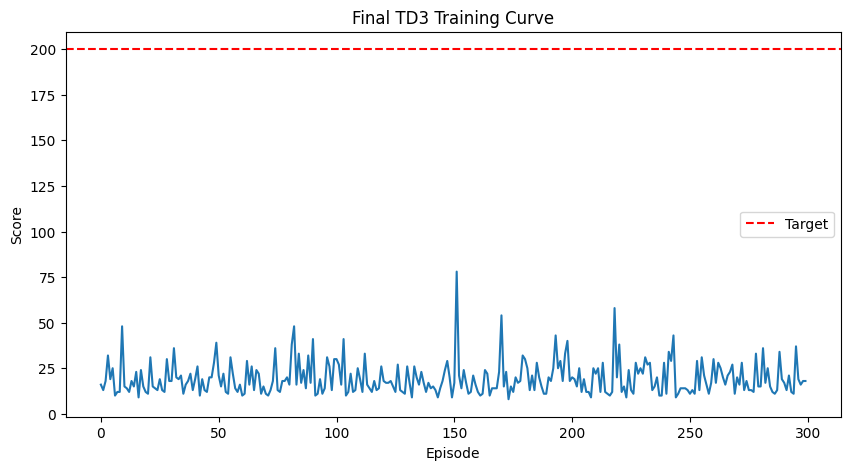

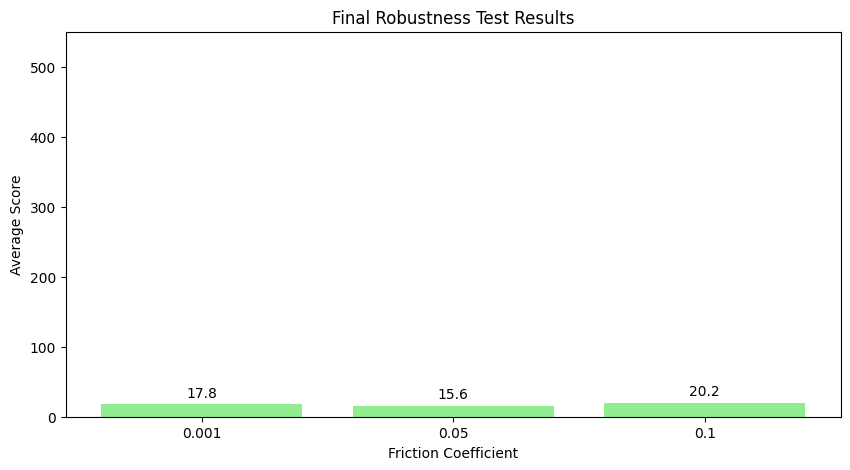

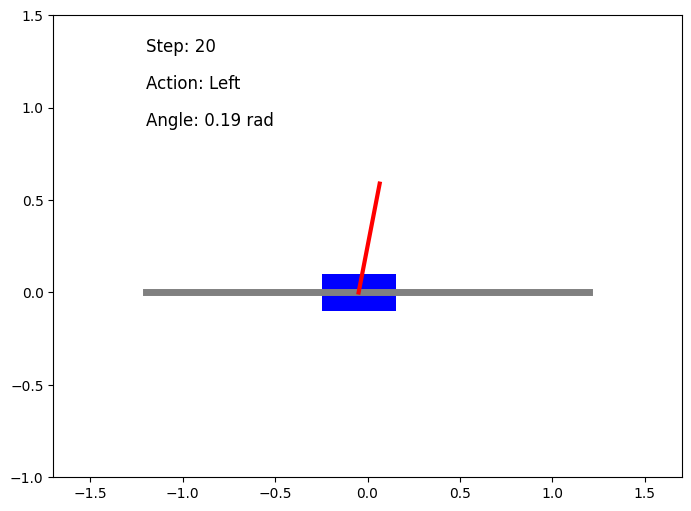

In [20]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import time
from collections import deque, namedtuple
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from IPython import display
import copy
%matplotlib inline

# Ensure running on CPU
device = torch.device("cpu")

# Fix numpy.bool8 error
np.bool8 = np.bool_

# Experience replay buffer
Experience = namedtuple('Experience', ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, *args):
        self.buffer.append(Experience(*args))

    def sample(self, batch_size):
        experiences = random.sample(self.buffer, k=batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.buffer)

# Policy network (Actor)
class Actor(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=32):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, action_size)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        return torch.softmax(self.fc2(x), dim=-1)

# Value network (Critic)
class Critic(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=32):
        super(Critic, self).__init__()
        self.q1_fc1 = nn.Linear(state_size + action_size, hidden_size)
        self.q1_fc2 = nn.Linear(hidden_size, 1)

    def forward(self, state, action):
        # Ensure action is in one-hot encoding format
        action_onehot = torch.zeros(action.size(0), 2).to(device)
        action_onehot.scatter_(1, action.unsqueeze(1), 1)

        # Combine state and one-hot encoded action
        sa = torch.cat([state, action_onehot], dim=1)
        q1 = torch.relu(self.q1_fc1(sa))
        q1 = self.q1_fc2(q1)
        return q1, q1

# TD3 Agent
class TD3Agent:
    def __init__(self, state_size, action_size, buffer_size=int(1e4),
                 batch_size=32, gamma=0.99, tau=1e-2,
                 lr_actor=1e-3, lr_critic=1e-3):

        self.state_size = state_size
        self.action_size = action_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau

        # Actor networks
        self.actor = Actor(state_size, action_size).to(device)
        self.actor_target = copy.deepcopy(self.actor)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr_actor)

        # Critic networks
        self.critic = Critic(state_size, action_size).to(device)
        self.critic_target = copy.deepcopy(self.critic)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=lr_critic)

        # Experience replay buffer
        self.memory = ReplayBuffer(buffer_size)

    def step(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)

        if len(self.memory) > self.batch_size:
            experiences = self.memory.sample(self.batch_size)
            self.learn(experiences)

    def act(self, state, add_noise=True):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.actor.eval()
        with torch.no_grad():
            action_probs = self.actor(state)
        self.actor.train()

        action = torch.multinomial(action_probs, 1).item()

        if add_noise and random.random() < 0.1:
            action = random.choice(range(self.action_size))

        return action

    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences

        # Update Critic
        with torch.no_grad():
            next_action_probs = self.actor_target(next_states)
            next_actions = torch.multinomial(next_action_probs, 1).squeeze(1)
            q1_target, q2_target = self.critic_target(next_states, next_actions)
            q_target = torch.min(q1_target, q2_target)
            q_target = rewards + (self.gamma * q_target * (1 - dones))

        q1_current, q2_current = self.critic(states, actions.squeeze(1))
        critic_loss = nn.MSELoss()(q1_current, q_target)

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Update Actor
        action_probs = self.actor(states)
        actions_sampled = torch.multinomial(action_probs, 1).squeeze(1)
        q1, _ = self.critic(states, actions_sampled)
        actor_loss = -q1.mean()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Update target networks
        self.soft_update(self.critic, self.critic_target)
        self.soft_update(self.actor, self.actor_target)

    def soft_update(self, local_model, target_model):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - self.tau) + local_param.data * self.tau)

# Custom CartPole environment
class CustomCartPole(gym.Wrapper):
    def __init__(self, env, friction_coef=None):
        super().__init__(env)
        self.friction_coef = friction_coef

    def reset(self, **kwargs):
        result = self.env.reset(** kwargs)
        if isinstance(result, tuple) and len(result) == 2:
            observation, info = result
        else:
            observation, info = result, {}

        if self.friction_coef is not None:
            if hasattr(self.env.unwrapped, 'sigma'):
                self.env.unwrapped.sigma = self.friction_coef
            elif hasattr(self.env.unwrapped, 'cart_friction'):
                self.env.unwrapped.cart_friction = self.friction_coef
            else:
                self.env.unwrapped.force_mag = 10.0 - (self.friction_coef * 50)
        return observation, info

# Train agent
def train_agent(target_score=200, max_episodes=300, max_t=500, print_every=50):
    env = gym.make('CartPole-v1')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    agent = TD3Agent(state_size, action_size)

    scores_deque = deque(maxlen=100)
    scores = []
    steps_to_target = None
    total_steps = 0

    # Training curve display
    plt.figure(figsize=(10, 5))
    display_handle = display.display(plt.gcf(), display_id=True)

    for i_episode in range(1, max_episodes+1):
        result = env.reset()
        state = result[0] if isinstance(result, tuple) else result

        score = 0
        for t in range(max_t):
            action = agent.act(state)
            step_result = env.step(action)

            if len(step_result) == 5:
                next_state, reward, terminated, truncated, _ = step_result
                done = terminated or truncated
            else:
                next_state, reward, done, _ = step_result

            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            total_steps += 1

            if done:
                break

        scores_deque.append(score)
        scores.append(score)

        # Check if target achieved
        if np.mean(scores_deque) >= target_score and steps_to_target is None:
            steps_to_target = total_steps
            print(f"\nEnvironment solved in {i_episode} episodes!")
            print(f"Steps to reach target: {steps_to_target}")

        # Update training curve
        if i_episode % print_every == 0:
            print(f"Episode {i_episode}\tAverage Score: {np.mean(scores_deque):.2f}")
            plt.clf()
            plt.plot(scores)
            plt.title(f'TD3 Training (Episode {i_episode})')
            plt.xlabel('Episode')
            plt.ylabel('Score')
            plt.axhline(y=target_score, color='r', linestyle='--', label='Target')
            plt.legend()
            display_handle.update(plt.gcf())

        # Early termination
        if steps_to_target is not None and i_episode > 100:
            break

    env.close()
    plt.clf()
    plt.plot(scores)
    plt.title('Final TD3 Training Curve')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.axhline(y=target_score, color='r', linestyle='--', label='Target')
    plt.legend()
    display_handle.update(plt.gcf())

    return agent, scores, steps_to_target

# Test robustness (updated to show average scores)
def test_robustness(agent, friction_coefficients=[0.001, 0.05, 0.1], num_episodes=5):
    robustness_results = {}

    # Create figure but don't display immediately
    fig, ax = plt.subplots(figsize=(10, 5))
    display_handle = None  # Initialize display handle as None

    for i, friction in enumerate(friction_coefficients):
        env = CustomCartPole(gym.make('CartPole-v1'), friction_coef=friction)
        scores = []

        for ep in range(num_episodes):
            result = env.reset()
            state = result[0] if isinstance(result, tuple) else result

            score = 0
            for _ in range(500):
                action = agent.act(state, add_noise=False)
                step_result = env.step(action)

                if len(step_result) == 5:
                    next_state, reward, terminated, truncated, _ = step_result
                    done = terminated or truncated
                else:
                    next_state, reward, done, _ = step_result

                score += reward
                state = next_state
                if done:
                    break
            scores.append(score)
            print(f"Friction coefficient {friction}, Episode {ep+1}/{num_episodes}, Score: {score}")

        # Calculate and store results
        success_rate = np.mean([1 if s >= 100 else 0 for s in scores])
        robustness_results[friction] = {
            'mean_score': np.mean(scores),
            'success_rate': success_rate
        }

        # Update plot - using average score for Y-axis
        ax.clear()
        # Only show processed friction coefficients
        processed_frictions = list(robustness_results.keys())
        mean_scores = [r['mean_score'] for r in robustness_results.values()]  # Use average scores

        ax.bar([str(f) for f in processed_frictions], mean_scores, color='skyblue')
        ax.set_title(f'Robustness Test (Completed {i+1}/{len(friction_coefficients)})')
        ax.set_xlabel('Friction Coefficient')
        ax.set_ylabel('Average Score')  # Y-axis label updated
        ax.set_ylim(0, 550)  # Adjusted for score range (max possible 500)

        # Add value labels
        for idx, score in enumerate(mean_scores):
            ax.text(idx, score + 10, f'{score:.1f}', ha='center')

        # Initialize display when first data is available, update afterward
        if display_handle is None:
            display_handle = display.display(fig, display_id=True)
        else:
            display_handle.update(fig)

        env.close()

    # Final display of complete results
    ax.clear()
    ax.bar([str(f) for f in robustness_results.keys()],
           [r['mean_score'] for r in robustness_results.values()], color='lightgreen')  # Use average scores
    ax.set_title('Final Robustness Test Results')
    ax.set_xlabel('Friction Coefficient')
    ax.set_ylabel('Average Score')  # Y-axis label updated
    ax.set_ylim(0, 550)

    # Add final value labels
    for idx, (friction, result) in enumerate(robustness_results.items()):
        ax.text(idx, result['mean_score'] + 10,
                f'{result["mean_score"]:.1f}', ha='center')

    display_handle.update(fig)

    return robustness_results

# Measure planning latency
def measure_planning_cost(agent, num_trials=500):
    env = gym.make('CartPole-v1')
    result = env.reset()
    state = result[0] if isinstance(result, tuple) else result

    state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)

    # Warm-up
    for _ in range(10):
        agent.act(state, add_noise=False)

    # Measure time
    start_time = time.time()
    for _ in range(num_trials):
        with torch.no_grad():
            agent.actor(state_tensor)
    end_time = time.time()

    avg_latency = (end_time - start_time) / num_trials * 1000  # milliseconds
    env.close()
    return avg_latency

# Visualize agent performance - using pure Matplotlib rendering
def visualize_agent(agent, max_steps=300):
    env = gym.make('CartPole-v1')
    result = env.reset()
    state = result[0] if isinstance(result, tuple) else result

    # Create plotting area
    fig, ax = plt.subplots(figsize=(10, 6))
    display_handle = display.display(fig, display_id=True)

    # Physical parameters
    cart_width = 0.4
    cart_height = 0.2
    pole_length = 0.6
    track_length = 2.4  # Total track length

    try:
        for step in range(max_steps):
            action = agent.act(state, add_noise=False)
            step_result = env.step(action)

            if len(step_result) == 5:
                next_state, reward, terminated, truncated, _ = step_result
                done = terminated or truncated
            else:
                next_state, reward, done, _ = step_result

            # Clear current plot
            ax.clear()

            # Draw track
            ax.plot([-track_length/2, track_length/2], [0, 0], 'gray', linewidth=5)

            # Get state variables
            x, x_dot, theta, theta_dot = state

            # Draw cart
            cart = Rectangle(
                (x - cart_width/2, -cart_height/2),  # Bottom-left position
                cart_width, cart_height,             # Width and height
                facecolor='blue'
            )
            ax.add_patch(cart)

            # Draw pole
            pole_end_x = x + np.sin(theta) * pole_length
            pole_end_y = np.cos(theta) * pole_length
            pole = Line2D(
                [x, pole_end_x], [0, pole_end_y],
                color='red', linewidth=3
            )
            ax.add_line(pole)  # Use add_line instead of add_patch for Line2D objects

            # Set plot range
            ax.set_xlim(-track_length/2 - 0.5, track_length/2 + 0.5)
            ax.set_ylim(-1, 1.5)
            ax.set_aspect('equal')

            # Add text information
            ax.text(-track_length/2, 1.3, f"Step: {step + 1}", fontsize=12)
            ax.text(-track_length/2, 1.1, f"Action: {'Left' if action == 0 else 'Right'}", fontsize=12)
            ax.text(-track_length/2, 0.9, f"Angle: {theta:.2f} rad", fontsize=12)

            # Update display
            display_handle.update(fig)

            state = next_state
            if done:
                print(f"Episode ended after {step + 1} steps")
                break

    except Exception as e:
        print(f"Error during visualization: {e}")
        print("Visualization skipped, but other results are unaffected")
    finally:
        env.close()

# Main function
def main():
    # Train agent (approximately 3-4 minutes)
    print("Starting TD3 agent training...")
    agent, scores, steps_to_target = train_agent()

    # Sample efficiency
    print(f"\nSample efficiency (steps to reach target): {steps_to_target}")

    # Test robustness (approximately 1 minute)
    print("\nTesting robustness under different friction coefficients...")
    robustness_results = test_robustness(agent)

    print("\nRobustness test results:")
    for friction, result in robustness_results.items():
        print(f"Friction coefficient {friction}: Average score {result['mean_score']:.2f}, Success rate {result['success_rate']:.2f}")

    # Measure planning latency
    print("\nMeasuring planning latency...")
    avg_latency = measure_planning_cost(agent)
    print(f"Planning latency (per-step inference time): {avg_latency:.4f} milliseconds")

    # Visualize agent performance
    print("\nDisplaying agent performance...")
    visualize_agent(agent)

if __name__ == "__main__":
    main()

COUNTERFACTUAL ANALYSIS FRAMEWORK
Initializing Counterfactual Analyzer...

1. Collecting factual trajectory...
Factual trajectory length: 35 steps
Total reward: 35.0

2. Generating counterfactual scenarios...
Generated 3 counterfactual scenarios

3. Measuring counterfactual consistency...

Action_Flip_Step20:
  physical_plausibility: 1.000
  temporal_coherence: 1.000
  causal_consistency: 0.000

State_Perturb_Step30:
  physical_plausibility: 1.000
  temporal_coherence: 1.000
  causal_consistency: 0.194

Force_Right_Step10:
  physical_plausibility: 1.000
  temporal_coherence: 1.000
  causal_consistency: 0.000

4. Visualizing counterfactual analysis...


/usr/local/lib/python3.12/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


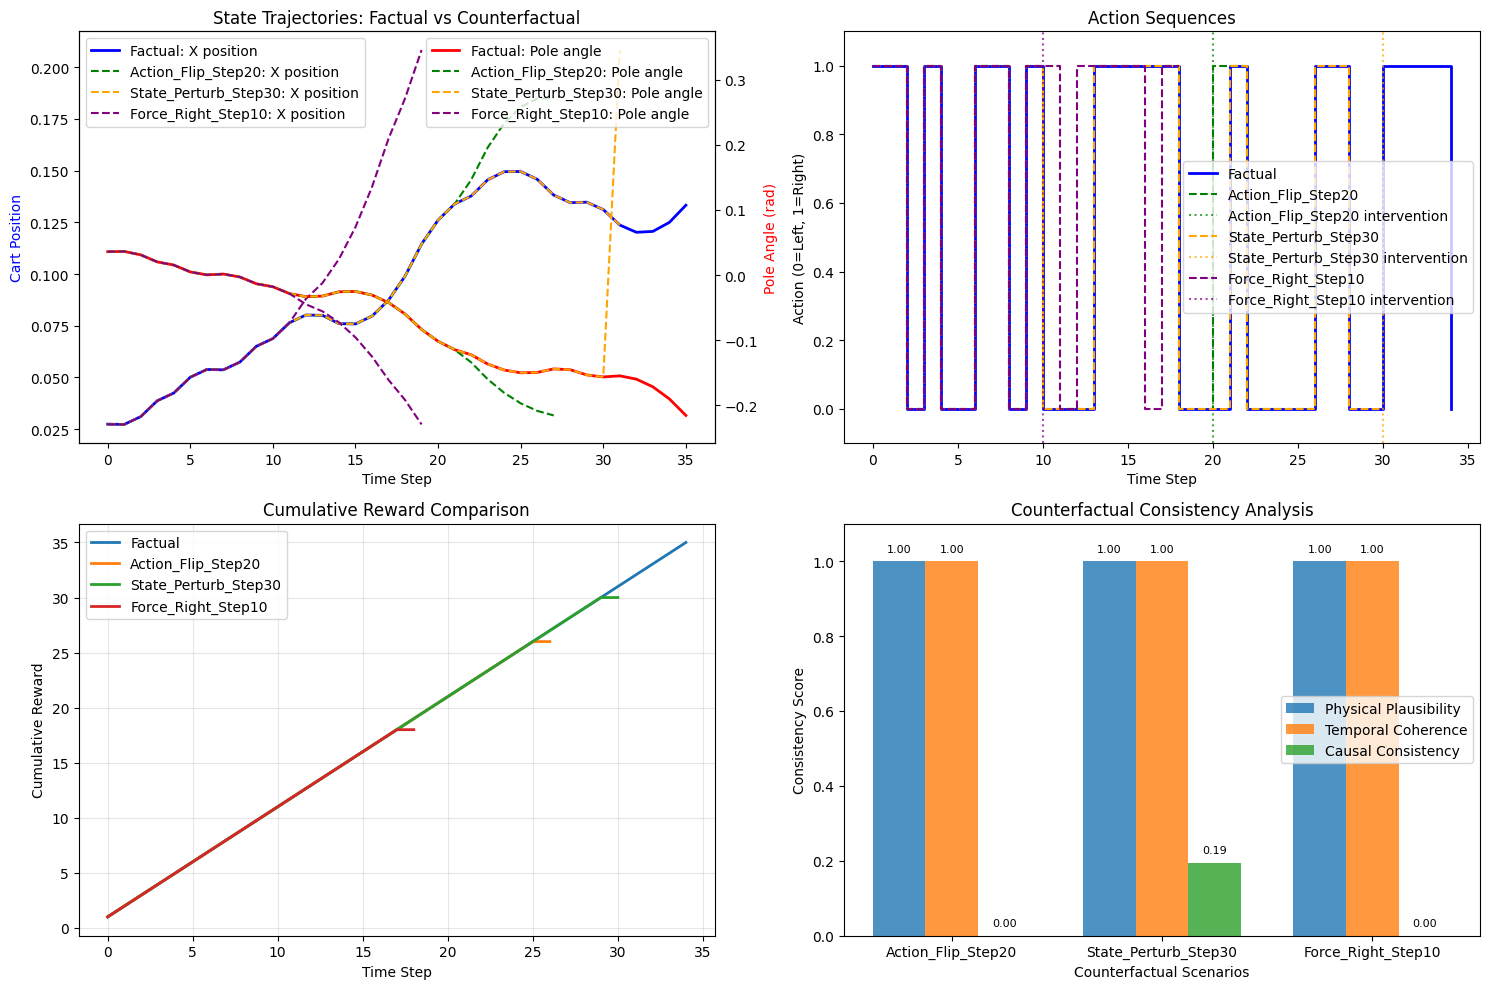


5. Proposing model correction strategies...

A. Prior Constraints Approach:
Applying physical prior constraints...
State bounds: {'position': [-2.4, 2.4], 'angle': [-0.2095, 0.2095], 'velocity': [-5.0, 5.0], 'angular_velocity': [-3.0, 3.0]}

B. Structural Regularization Approach:
Applying structural regularization with weight 0.1

C. Procedural Rules Approach:
Applying procedural rules:
  - if pole_angle > 0.15: push_cart_left
  - if pole_angle < -0.15: push_cart_right
  - if cart_near_boundary: push_away_from_boundary

COUNTERFACTUAL ANALYSIS COMPLETED


In [52]:
# =============================================================================
# 2. Counterfactual Analysis Framework
# =============================================================================

import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from IPython import display
import copy

class CounterfactualAnalyzer:
    def __init__(self, agent, env_name='CartPole-v1'):
        self.agent = agent
        self.env = gym.make(env_name)
        self.device = torch.device("cpu")

    def collect_factual_trajectory(self, max_steps=200, seed=None):
        """Collect a factual trajectory from the trained agent"""
        if seed is not None:
            self.env.seed(seed)

        result = self.env.reset()
        state = result[0] if isinstance(result, tuple) else result

        trajectory = {
            'states': [state.copy()],
            'actions': [],
            'rewards': [],
            'dones': [],
            'info': []
        }

        for step in range(max_steps):
            action = self.agent.act(state, add_noise=False)
            step_result = self.env.step(action)

            if len(step_result) == 5:
                next_state, reward, terminated, truncated, info = step_result
                done = terminated or truncated
            else:
                next_state, reward, done, info = step_result

            trajectory['actions'].append(action)
            trajectory['rewards'].append(reward)
            trajectory['dones'].append(done)
            trajectory['info'].append(info)
            trajectory['states'].append(next_state.copy())

            state = next_state
            if done:
                break

        return trajectory

    def generate_counterfactual(self, factual_traj, intervention_step,
                              intervention_type='action', intervention_value=None,
                              physics_prior=True):
        """
        Generate counterfactual trajectory by intervening at specified step

        Args:
            factual_traj: Original factual trajectory
            intervention_step: Step at which to intervene (0-indexed)
            intervention_type: 'action' or 'state'
            intervention_value: New value for intervention (if None, uses opposite action)
            physics_prior: Whether to apply physics-based state transitions
        """
        cf_trajectory = {
            'states': factual_traj['states'][:intervention_step+1].copy(),
            'actions': factual_traj['actions'][:intervention_step].copy(),
            'rewards': factual_traj['rewards'][:intervention_step].copy(),
            'dones': factual_traj['dones'][:intervention_step].copy(),
            'info': factual_traj['info'][:intervention_step].copy(),
            'intervention_step': intervention_step,
            'intervention_type': intervention_type
        }

        current_state = cf_trajectory['states'][-1].copy()

        # Apply intervention
        if intervention_type == 'action':
            if intervention_value is None:
                # Default: take opposite action
                original_action = factual_traj['actions'][intervention_step]
                intervention_value = 1 - original_action  # Flip 0<->1

            cf_trajectory['actions'].append(intervention_value)
            action = intervention_value

        elif intervention_type == 'state':
            if intervention_value is None:
                # Default: perturb pole angle
                intervention_value = current_state.copy()
                intervention_value[2] += 0.5  # Add 0.5 rad to pole angle
            current_state = intervention_value
            action = self.agent.act(current_state, add_noise=False)
            cf_trajectory['actions'].append(action)

        # Continue trajectory from intervention point
        state = current_state
        for step in range(intervention_step + 1, len(factual_traj['actions'])):
            if physics_prior:
                # Use simplified physics model for counterfactual transitions
                next_state = self._physics_based_transition(state, action)
            else:
                # Use actual environment (less counterfactual but more accurate)
                step_result = self.env.step(action)
                if len(step_result) == 5:
                    next_state, reward, terminated, truncated, info = step_result
                    done = terminated or truncated
                else:
                    next_state, reward, done, info = step_result

            reward = self._calculate_reward(next_state)
            done = self._check_termination(next_state)

            cf_trajectory['states'].append(next_state.copy())
            cf_trajectory['rewards'].append(reward)
            cf_trajectory['dones'].append(done)
            cf_trajectory['info'].append({})

            if done:
                break

            state = next_state
            action = self.agent.act(state, add_noise=False)
            cf_trajectory['actions'].append(action)

        return cf_trajectory

    def _physics_based_transition(self, state, action):
        """Simplified physics model for counterfactual state transitions"""
        x, x_dot, theta, theta_dot = state

        # CartPole physics parameters
        gravity = 9.8
        masscart = 1.0
        masspole = 0.1
        total_mass = masspole + masscart
        length = 0.5  # actually half the pole's length
        polemass_length = masspole * length
        force_mag = 10.0
        tau = 0.02  # seconds between state updates

        # Force based on action
        force = force_mag if action == 1 else -force_mag

        # Physics calculations
        costheta = np.cos(theta)
        sintheta = np.sin(theta)

        temp = (force + polemass_length * theta_dot ** 2 * sintheta) / total_mass
        thetaacc = (gravity * sintheta - costheta * temp) / (length * (4.0/3.0 - masspole * costheta ** 2 / total_mass))
        xacc = temp - polemass_length * thetaacc * costheta / total_mass

        # Update state using Euler integration
        x = x + tau * x_dot
        x_dot = x_dot + tau * xacc
        theta = theta + tau * theta_dot
        theta_dot = theta_dot + tau * thetaacc

        return np.array([x, x_dot, theta, theta_dot])

    def _calculate_reward(self, state):
        """Calculate reward based on state"""
        x, x_dot, theta, theta_dot = state
        # Reward is 1 if pole is within reasonable bounds
        if abs(x) < 2.4 and abs(theta) < 0.2095:  # ~12 degrees
            return 1.0
        return 0.0

    def _check_termination(self, state):
        """Check if episode should terminate"""
        x, x_dot, theta, theta_dot = state
        return bool(abs(x) > 2.4 or abs(theta) > 0.2095)

    def measure_consistency(self, factual_traj, cf_traj, metrics=None):
        """
        Measure consistency between factual and counterfactual trajectories
        """
        if metrics is None:
            metrics = ['physical_plausibility', 'temporal_coherence', 'causal_consistency']

        consistency_scores = {}

        if 'physical_plausibility' in metrics:
            consistency_scores['physical_plausibility'] = self._physical_plausibility_score(cf_traj)

        if 'temporal_coherence' in metrics:
            consistency_scores['temporal_coherence'] = self._temporal_coherence_score(factual_traj, cf_traj)

        if 'causal_consistency' in metrics:
            consistency_scores['causal_consistency'] = self._causal_consistency_score(factual_traj, cf_traj)

        return consistency_scores

    def _physical_plausibility_score(self, cf_traj):
        """Score based on physical plausibility of the trajectory"""
        states = np.array(cf_traj['states'])

        # Check for physical constraints violations
        score = 1.0

        # Penalize large instantaneous changes in velocity
        if len(states) > 1:
            vel_changes = np.abs(np.diff(states[:, 1]))  # x_dot changes
            large_vel_changes = np.sum(vel_changes > 5.0)  # Arbitrary threshold
            score -= large_vel_changes * 0.1

            ang_vel_changes = np.abs(np.diff(states[:, 3]))  # theta_dot changes
            large_ang_changes = np.sum(ang_vel_changes > 2.0)  # Arbitrary threshold
            score -= large_ang_changes * 0.1

        return max(0.0, score)

    def _temporal_coherence_score(self, factual_traj, cf_traj):
        """Score based on temporal coherence between trajectories"""
        min_len = min(len(factual_traj['states']), len(cf_traj['states']))

        if min_len <= 1:
            return 0.0

        # Compare state dynamics before intervention
        intervention_step = cf_traj['intervention_step']
        pre_intervention_steps = min(intervention_step, min_len - 1)

        if pre_intervention_steps > 0:
            factual_pre = np.array(factual_traj['states'][:pre_intervention_steps])
            cf_pre = np.array(cf_traj['states'][:pre_intervention_steps])

            # Should be identical before intervention
            state_diff = np.mean(np.abs(factual_pre - cf_pre))
            coherence = max(0.0, 1.0 - state_diff * 10)  # Scale factor
        else:
            coherence = 1.0

        return coherence

    def _causal_consistency_score(self, factual_traj, cf_traj):
        """Score based on causal consistency of the intervention"""
        intervention_step = cf_traj['intervention_step']

        # Check if intervention caused reasonable changes
        if intervention_step >= len(factual_traj['states']) - 1:
            return 0.5

        # Compare immediate effects of intervention
        factual_next = factual_traj['states'][intervention_step + 1]
        cf_next = cf_traj['states'][intervention_step + 1]

        state_diff = np.abs(factual_next - cf_next)

        # Reasonable difference based on intervention type
        if cf_traj['intervention_type'] == 'action':
            expected_diff = 0.1  # Small changes expected for action flip
        else:
            expected_diff = 0.5  # Larger changes expected for state intervention

        consistency = max(0.0, 1.0 - np.mean(state_diff) / expected_diff)

        return consistency

    def visualize_counterfactuals(self, factual_traj, cf_trajectories, max_display_steps=50):
        """Visualize factual and counterfactual trajectories"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Plot 1: State trajectories comparison
        self._plot_state_comparison(axes[0, 0], factual_traj, cf_trajectories, max_display_steps)

        # Plot 2: Action sequences
        self._plot_action_sequences(axes[0, 1], factual_traj, cf_trajectories, max_display_steps)

        # Plot 3: Reward comparison
        self._plot_reward_comparison(axes[1, 0], factual_traj, cf_trajectories)

        # Plot 4: Consistency scores
        self._plot_consistency_scores(axes[1, 1], factual_traj, cf_trajectories)

        plt.tight_layout()
        plt.show()

    def _plot_state_comparison(self, ax, factual_traj, cf_trajectories, max_steps):
        """Plot state variable comparisons"""
        steps = range(min(len(factual_traj['states']), max_steps))

        # Plot cart position
        factual_x = [state[0] for state in factual_traj['states'][:max_steps]]
        ax.plot(steps, factual_x, 'b-', linewidth=2, label='Factual: X position')

        # Plot pole angle
        ax2 = ax.twinx()
        factual_theta = [state[2] for state in factual_traj['states'][:max_steps]]
        ax2.plot(steps, factual_theta, 'r-', linewidth=2, label='Factual: Pole angle')

        # Plot counterfactuals
        colors = ['green', 'orange', 'purple']
        for i, (cf_name, cf_traj) in enumerate(cf_trajectories.items()):
            if i >= len(colors):
                break
            cf_x = [state[0] for state in cf_traj['states'][:max_steps]]
            ax.plot(steps[:len(cf_x)], cf_x, '--', color=colors[i],
                   linewidth=1.5, label=f'{cf_name}: X position')

            cf_theta = [state[2] for state in cf_traj['states'][:max_steps]]
            ax2.plot(steps[:len(cf_theta)], cf_theta, '--', color=colors[i],
                    linewidth=1.5, label=f'{cf_name}: Pole angle')

        ax.set_xlabel('Time Step')
        ax.set_ylabel('Cart Position', color='b')
        ax2.set_ylabel('Pole Angle (rad)', color='r')
        ax.set_title('State Trajectories: Factual vs Counterfactual')
        ax.legend(loc='upper left')
        ax2.legend(loc='upper right')

    def _plot_action_sequences(self, ax, factual_traj, cf_trajectories, max_steps):
        """Plot action sequences comparison"""
        steps = range(min(len(factual_traj['actions']), max_steps))
        factual_actions = factual_traj['actions'][:max_steps]

        ax.step(steps, factual_actions, 'b-', linewidth=2, label='Factual', where='post')

        colors = ['green', 'orange', 'purple']
        for i, (cf_name, cf_traj) in enumerate(cf_trajectories.items()):
            if i >= len(colors):
                break
            intervention_step = cf_traj['intervention_step']
            cf_actions = cf_traj['actions'][:max_steps]

            ax.step(steps[:len(cf_actions)], cf_actions, '--', color=colors[i],
                   linewidth=1.5, label=cf_name, where='post')

            # Mark intervention point
            if intervention_step < max_steps:
                ax.axvline(x=intervention_step, color=colors[i], linestyle=':',
                          alpha=0.7, label=f'{cf_name} intervention')

        ax.set_xlabel('Time Step')
        ax.set_ylabel('Action (0=Left, 1=Right)')
        ax.set_title('Action Sequences')
        ax.legend()
        ax.set_ylim(-0.1, 1.1)

    def _plot_reward_comparison(self, ax, factual_traj, cf_trajectories):
        """Plot cumulative reward comparison"""
        trajectories = [('Factual', factual_traj)] + list(cf_trajectories.items())

        for name, traj in trajectories:
            cumulative_rewards = np.cumsum(traj['rewards'])
            steps = range(len(cumulative_rewards))
            ax.plot(steps, cumulative_rewards, label=name, linewidth=2)

        ax.set_xlabel('Time Step')
        ax.set_ylabel('Cumulative Reward')
        ax.set_title('Cumulative Reward Comparison')
        ax.legend()
        ax.grid(True, alpha=0.3)

    def _plot_consistency_scores(self, ax, factual_traj, cf_trajectories):
        """Plot consistency scores for counterfactuals"""
        cf_names = []
        physical_scores = []
        temporal_scores = []
        causal_scores = []

        for cf_name, cf_traj in cf_trajectories.items():
            scores = self.measure_consistency(factual_traj, cf_traj)
            cf_names.append(cf_name)
            physical_scores.append(scores['physical_plausibility'])
            temporal_scores.append(scores['temporal_coherence'])
            causal_scores.append(scores['causal_consistency'])

        x = np.arange(len(cf_names))
        width = 0.25

        ax.bar(x - width, physical_scores, width, label='Physical Plausibility', alpha=0.8)
        ax.bar(x, temporal_scores, width, label='Temporal Coherence', alpha=0.8)
        ax.bar(x + width, causal_scores, width, label='Causal Consistency', alpha=0.8)

        ax.set_xlabel('Counterfactual Scenarios')
        ax.set_ylabel('Consistency Score')
        ax.set_title('Counterfactual Consistency Analysis')
        ax.set_xticks(x)
        ax.set_xticklabels(cf_names)
        ax.legend()
        ax.set_ylim(0, 1.1)

        # Add value labels
        for i, (p, t, c) in enumerate(zip(physical_scores, temporal_scores, causal_scores)):
            ax.text(i - width, p + 0.02, f'{p:.2f}', ha='center', va='bottom', fontsize=8)
            ax.text(i, t + 0.02, f'{t:.2f}', ha='center', va='bottom', fontsize=8)
            ax.text(i + width, c + 0.02, f'{c:.2f}', ha='center', va='bottom', fontsize=8)

class ModelCorrector:
    """Proposed methods for correcting model inconsistencies"""

    def __init__(self, agent):
        self.agent = agent

    def apply_prior_constraints(self, state_bounds=None, action_smoothing=True):
        """Apply physical prior constraints to the agent"""
        if state_bounds is None:
            state_bounds = {
                'position': [-2.4, 2.4],
                'angle': [-0.2095, 0.2095],  # ~12 degrees
                'velocity': [-5.0, 5.0],
                'angular_velocity': [-3.0, 3.0]
            }

        print("Applying physical prior constraints...")
        print(f"State bounds: {state_bounds}")

        # This would typically involve modifying the agent's action selection
        # or adding a post-processing step to ensure physical constraints

    def apply_structural_regularization(self, consistency_weight=0.1):
        """Add structural regularization to training"""
        print(f"Applying structural regularization with weight {consistency_weight}")

        # This would involve modifying the loss function during training
        # to include consistency terms between factual and counterfactual predictions

    def apply_procedural_rules(self, rules=None):
        """Apply procedural rules for action selection"""
        if rules is None:
            rules = [
                "if pole_angle > 0.15: push_cart_left",
                "if pole_angle < -0.15: push_cart_right",
                "if cart_near_boundary: push_away_from_boundary"
            ]

        print("Applying procedural rules:")
        for rule in rules:
            print(f"  - {rule}")

        # This would involve overriding agent actions in specific situations
        # based on domain knowledge

def run_counterfactual_analysis():
    """Main function to run counterfactual analysis"""
    print("=" * 60)
    print("COUNTERFACTUAL ANALYSIS FRAMEWORK")
    print("=" * 60)

    # First, we need a trained agent from question 1
    try:
        # You would use your trained agent here
        # For demonstration, we'll create a simple environment to show the structure
        env = gym.make('CartPole-v1')
        state_size = env.observation_space.shape[0]
        action_size = env.action_space.n

        # Create a simple agent for demonstration
        # In practice, use your trained agent from question 1
        demo_agent = TD3Agent(state_size, action_size)

        print("Initializing Counterfactual Analyzer...")
        analyzer = CounterfactualAnalyzer(demo_agent)

        # Collect factual trajectory
        print("\n1. Collecting factual trajectory...")
        factual_traj = analyzer.collect_factual_trajectory(max_steps=100, seed=42)
        print(f"Factual trajectory length: {len(factual_traj['actions'])} steps")
        print(f"Total reward: {sum(factual_traj['rewards'])}")

        # Generate counterfactual scenarios
        print("\n2. Generating counterfactual scenarios...")

        cf_scenarios = {}

        # Scenario 1: Action intervention at step 20
        cf1 = analyzer.generate_counterfactual(
            factual_traj, intervention_step=20,
            intervention_type='action', intervention_value=None  # None = opposite action
        )
        cf_scenarios['Action_Flip_Step20'] = cf1

        # Scenario 2: State intervention at step 30
        cf2 = analyzer.generate_counterfactual(
            factual_traj, intervention_step=30,
            intervention_type='state', intervention_value=None  # None = perturb angle
        )
        cf_scenarios['State_Perturb_Step30'] = cf2

        # Scenario 3: Early action intervention
        cf3 = analyzer.generate_counterfactual(
            factual_traj, intervention_step=10,
            intervention_type='action', intervention_value=1  # Force right action
        )
        cf_scenarios['Force_Right_Step10'] = cf3

        print(f"Generated {len(cf_scenarios)} counterfactual scenarios")

        # Measure consistency
        print("\n3. Measuring counterfactual consistency...")
        for cf_name, cf_traj in cf_scenarios.items():
            scores = analyzer.measure_consistency(factual_traj, cf_traj)
            print(f"\n{cf_name}:")
            for metric, score in scores.items():
                print(f"  {metric}: {score:.3f}")

        # Visualize results
        print("\n4. Visualizing counterfactual analysis...")
        analyzer.visualize_counterfactuals(factual_traj, cf_scenarios)

        # Propose model corrections
        print("\n5. Proposing model correction strategies...")
        corrector = ModelCorrector(demo_agent)

        print("\nA. Prior Constraints Approach:")
        corrector.apply_prior_constraints()

        print("\nB. Structural Regularization Approach:")
        corrector.apply_structural_regularization()

        print("\nC. Procedural Rules Approach:")
        corrector.apply_procedural_rules()

        print("\n" + "=" * 60)
        print("COUNTERFACTUAL ANALYSIS COMPLETED")
        print("=" * 60)

        env.close()

    except Exception as e:
        print(f"Error in counterfactual analysis: {e}")
        print("Please ensure you have a trained agent from question 1")

# Additional utility function for detailed counterfactual examination
def examine_counterfactual_differences(factual_traj, cf_traj, steps_around_intervention=5):
    """Examine detailed differences around intervention point"""
    intervention_step = cf_traj['intervention_step']

    start_idx = max(0, intervention_step - steps_around_intervention)
    end_idx = min(len(factual_traj['states']), intervention_step + steps_around_intervention + 1)

    print(f"\nDetailed comparison around intervention (step {intervention_step}):")
    print("Step | Factual State | Counterfactual State | Difference")
    print("-" * 70)

    for step in range(start_idx, end_idx):
        if step < len(factual_traj['states']) and step < len(cf_traj['states']):
            fact_state = factual_traj['states'][step]
            cf_state = cf_traj['states'][step]
            diff = np.abs(fact_state - cf_state)

            marker = "***" if step == intervention_step else ""
            print(f"{step:4d} | [{fact_state[0]:6.3f}, {fact_state[2]:6.3f}] | "
                  f"[{cf_state[0]:6.3f}, {cf_state[2]:6.3f}] | "
                  f"[{diff[0]:6.3f}, {diff[2]:6.3f}] {marker}")

# Run the counterfactual analysis
if __name__ == "__main__":
    run_counterfactual_analysis()